**IMPORT PACKAGES**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import os

import pandas as pd

import numpy as np

from numpy.lib.stride_tricks import sliding_window_view

import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

**LOAD DATA**

In [ ]:
## TO UPLOAD ##
from google.colab import files
uploaded = files.upload()

Saving mentalHealthSupport_trends.csv to mentalHealthSupport_trends.csv


In [ ]:
file = 'mentalHealthSupport_trends.csv'
df = pd.read_csv(file, parse_dates=['Week'], header = 1)
df.head()

,Week,Mental Health Support: (United States)
0,2020-12-27,21
1,2021-01-03,29
2,2021-01-10,32
3,2021-01-17,32
4,2021-01-24,43


**SET WINDOW**

In [ ]:
df['Year'] = df['Week'].dt.year
df['Month'] = df['Week'].dt.month
df['DayOfWeek'] = df['Week'].dt.dayofweek

train = df.iloc[:150]
test = df.iloc[150:]

X_train = train[['Year', 'Month', 'DayOfWeek']]
y_train = train['Mental Health Support: (United States)']

X_test = test[['Year', 'Month', 'DayOfWeek']]
y_test = test['Mental Health Support: (United States)']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

**LSTM MODEL**

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dense(units=1))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X_train_scaled, y_train, epochs=5)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2785.6636
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2631.5254 
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2769.4148 
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2625.4592 
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2607.2961 


**RESULTS**

In [ ]:
test_predictions = model.predict(X_test_scaled)
test_predictions_reshaped = test_predictions.reshape(-1, 1)
test_predictions_reshaped = np.hstack([test_predictions_reshaped] * 3)
test_predictions_original = scaler.inverse_transform(test_predictions_reshaped)[:, 0]

actuals_original = y_test.values

mse = mean_squared_error(actuals_original, test_predictions_original)
mae = mean_absolute_error(actuals_original, test_predictions_original)
rmse = np.sqrt(mse)
print(mse, mae, rmse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3789442.352993226 1946.5922241210938 1946.6490061110724


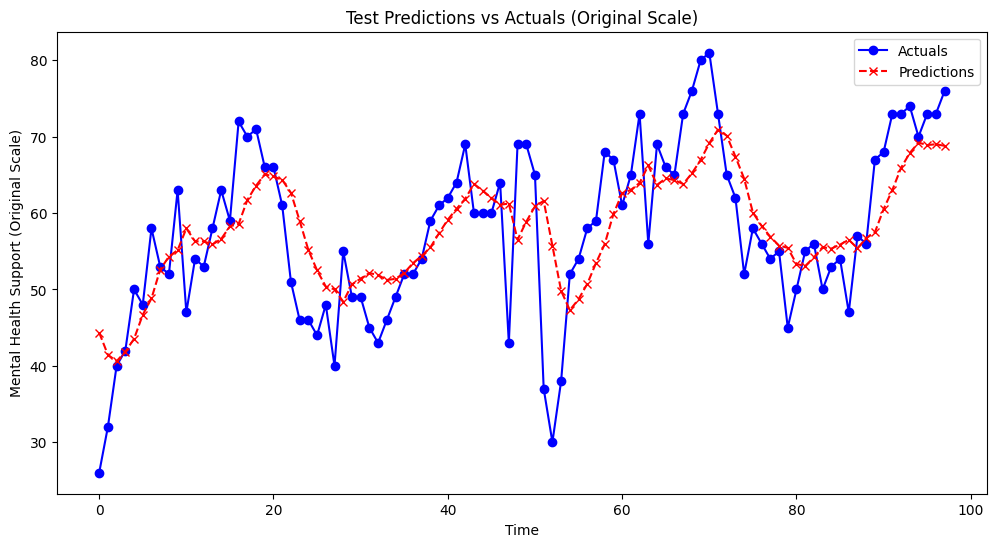

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(test_results['Date'], test_results['Actuals'], label='Actuals', color='blue', linestyle='-', marker='o')
plt.plot(test_results['Date'], test_results['Test Predictions'], label='Predictions', color='red', linestyle='o', marker='x')
plt.title('Test Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Mental Health Support Search Value')
plt.xticks(rotation=45)  # Rotate the date labels for better visibility
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

**EVALUATE**

In [ ]:
rmse = np.sqrt(mean_squared_error(actuals, test_predictions))
mae = mean_absolute_error(actuals, test_predictions)
print(rmse)
print(mae)

0.13076157235036676
0.10076854198562854
